In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
seed = 12
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print('done')

import warnings
warnings.filterwarnings('ignore')

2024-04-07 20:30:54.424576: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 20:30:54.424671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 20:30:54.558703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done


## Data

In [2]:
# change current directory
os.chdir('/kaggle/input/asl-alphabet')
os.listdir(os.getcwd())

['asl_alphabet_test', 'asl_alphabet_train']

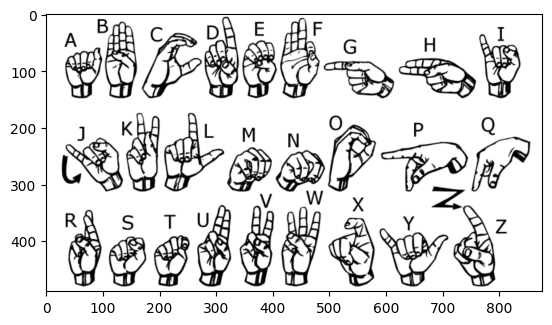

In [3]:
# all sign language characters 
img = plt.imread('/kaggle/input/sign-language-mnist/american_sign_language.PNG')
plt.imshow(img)

### Load data

In [4]:
# as all images in one folder, i will load them in data frame to split them to train, validation and test
data_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
data = []
for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        
        data.append((img_path, class_folder))

In [5]:
data[:4]

[('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N1337.jpg',
  'N'),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N1637.jpg',
  'N'),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N20.jpg',
  'N'),
 ('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/N/N222.jpg',
  'N')]

In [6]:
df = pd.DataFrame(data, columns = ['filepath', 'label'])

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
df.sample(5)

,filepath,label
29104,/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/U/U2310.jpg,U
65136,/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/Z/Z2638.jpg,Z
73299,/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/L/L685.jpg,L
20978,/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/F/F174.jpg,F
30608,/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/M/M957.jpg,M


In [9]:
from sklearn.model_selection import train_test_split

train_df, _df= train_test_split(df, train_size=.8, shuffle=True, random_state=seed)
val_df, test_df = train_test_split(_df, test_size=.5, shuffle=True, random_state=seed)

In [10]:
print(f'training data shape: {train_df.shape}',
      f'validation data shape: {val_df.shape}',
      f'test data shape: {test_df.shape}')

training data shape: (69600, 2) validation data shape: (8700, 2) test data shape: (8700, 2)


In [11]:
train_augmentation = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_augmentation = ImageDataGenerator(rescale=1./255)

In [15]:
train_dataset = train_augmentation.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    
    y_col='label',       
    target_size=(150, 150),  
    batch_size=32,
    class_mode='categorical',  
    shuffle=True,        
    seed=seed           
)

val_dataset = val_augmentation.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',    
    y_col='label',       
    target_size=(150, 150),  
    batch_size=32,
    class_mode='categorical',  
    shuffle=False       
)

test_dataset = val_augmentation.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',    
    y_col='label',       
    target_size=(150, 150),  
    batch_size=32,
    class_mode='categorical',  
    shuffle=False       
)

print('done')

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
done


In [13]:
# number of batches
len(train_dataset)

2175

In [14]:
# get a batch
train_batch = next(iter(train_dataset))
len(train_batch[0])

32

In [16]:
# labels
train_batch[1][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [17]:
# Get classes names 
class_dictionary = train_dataset.class_indices
print(class_dictionary)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [18]:
classes = list(class_dictionary.keys())
print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [19]:
classes[0], classes[-1]

('A', 'space')

## Images visualization

In [20]:
# get the right class index from label 
print(f'label: {train_batch[1][4]} /ntype: {type(train_batch[1][4])}')
index = np.where(train_batch[1][4] == 1)
type(index), 'one at index: ', index[0][0]

label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] /ntype: <class 'numpy.ndarray'>


(tuple, 'one at index: ', 12)

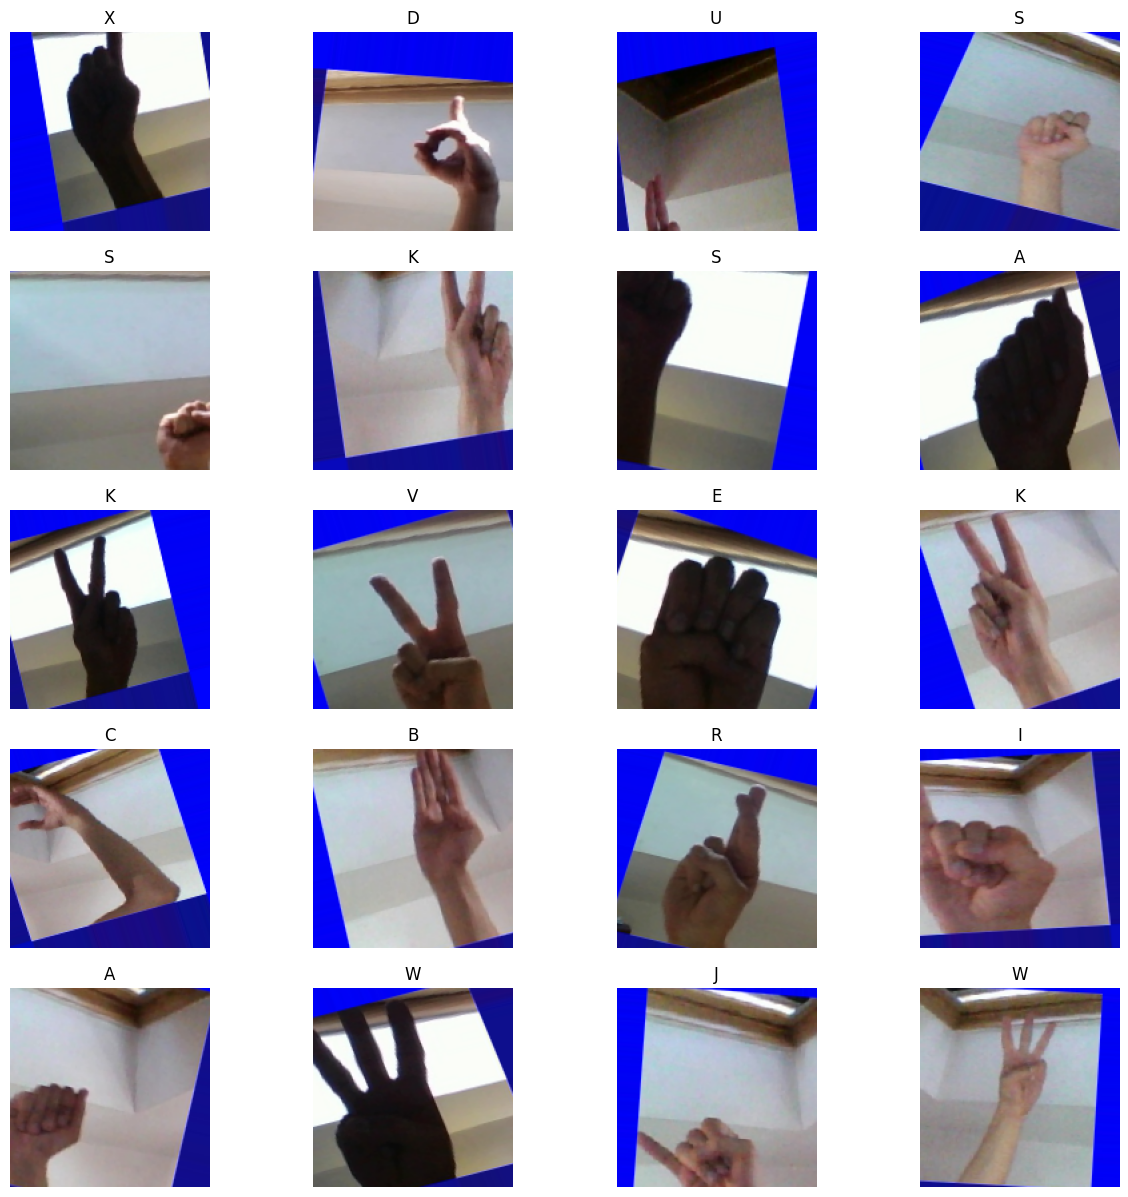

In [21]:
train_batch = next(iter(train_dataset))

fig, ax = plt.subplots(5,4, figsize=(15,15))

for i in range(20):
    row = i // 4  # Calculate row index
    col = i % 4   # Calculate column index
    scaled_images = train_batch[0][i] * 255.0
    ax[row, col].imshow(scaled_images.astype("uint8"))
    index =  np.where(train_batch[1][i] == 1)[0][0]
    ax[row, col].set_title(classes[index])  # Use set_title instead of title
    ax[row, col].axis("off")

## EDA
- Check labels balancing 

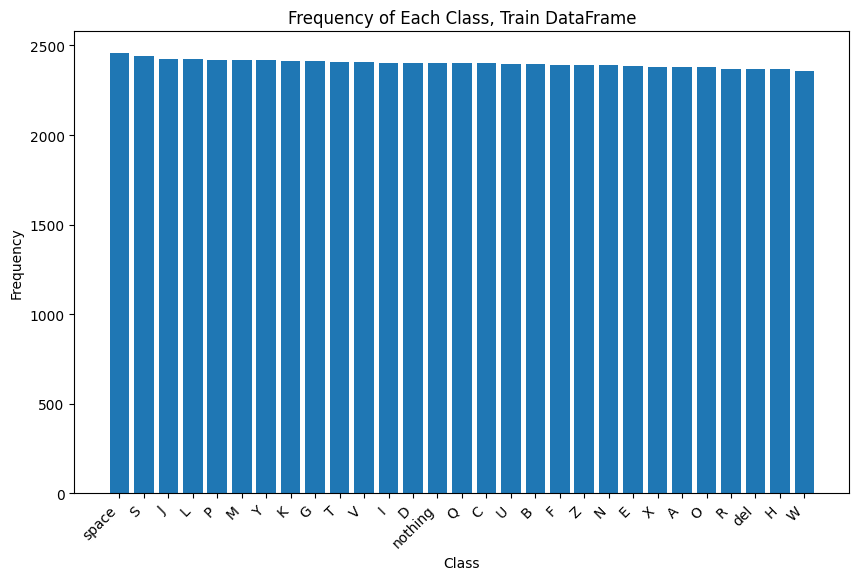

In [20]:
class_counts = train_df['label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.title('Frequency of Each Class, Train DataFrame')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.show()

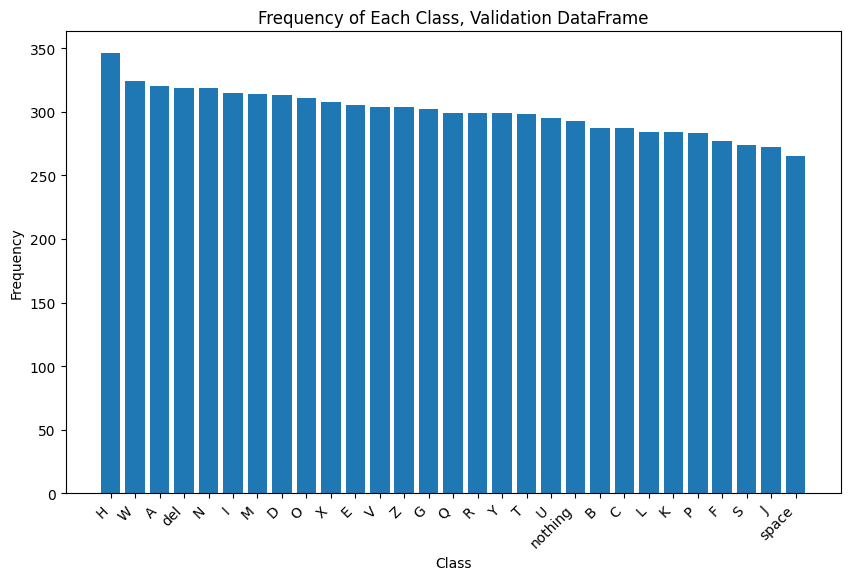

In [21]:
class_counts = val_df['label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.title('Frequency of Each Class, Validation DataFrame')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.show()

## Model

In [22]:
# Load the Xception model pretrained on ImageNet
base_model = xception.Xception(weights='imagenet', 
                               include_top=False,
                               input_shape = (150, 150, 3),
                               pooling='max')



# Print model summary
base_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 74, 74,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 74, 74,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 72, 72,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 72, 72,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 72, 72,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 72, 72,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 72, 72,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 72, 72,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 72, 72,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 72, 72,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 36, 36,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 36, 36,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 36, 36,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 36, 36,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 36, 36,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [41]:
# Define the input layer
inputs = base_model.input

# Get the output of the base model
base_model_output = base_model.output

# Add BatchNormalization layer
x = BatchNormalization()(base_model_output)

# Add Dense layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add Dropout layer with dropout rate of 0.5
x = Dropout(0.5)(x)

# Add Dense layer with 29 units 
outputs = Dense(29, activation='softmax')(x)

# Create the custom model
model = Model(inputs=inputs, outputs=outputs)

In [27]:
# model.summary()

In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath for saving the best model
filepath = '/kaggle/working/best_model.keras'

# Create a ModelCheckpoint callback to save the best model
checkpointer = ModelCheckpoint(filepath=filepath, save_best_only=True, verbose=1)

In [44]:
history = model.fit(train_dataset,
                    epochs=10, 
                    validation_data= val_dataset,
                    callbacks = [checkpointer],
                    verbose=1)

Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9247 - loss: 0.3398
Epoch 1: val_loss improved from inf to 0.01505, saving model to /kaggle/working/best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 537s 225ms/step - accuracy: 0.9248 - loss: 0.3398 - val_accuracy: 0.9947 - val_loss: 0.0150
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9628 - loss: 0.1714
Epoch 2: val_loss did not improve from 0.01505
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 439s 201ms/step - accuracy: 0.9628 - loss: 0.1714 - val_accuracy: 0.9855 - val_loss: 0.0690
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9691 - loss: 0.1318
Epoch 3: val_loss improved from 0.01505 to 0.00990, saving model to /kaggle/working/best_model.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 439s 201ms/step - accuracy: 0.9691 - loss: 0.1318 - val_accuracy: 0.9970 - val_loss: 0.0099
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9745 - loss: 0.1139
Epoch 4: val_loss did not 

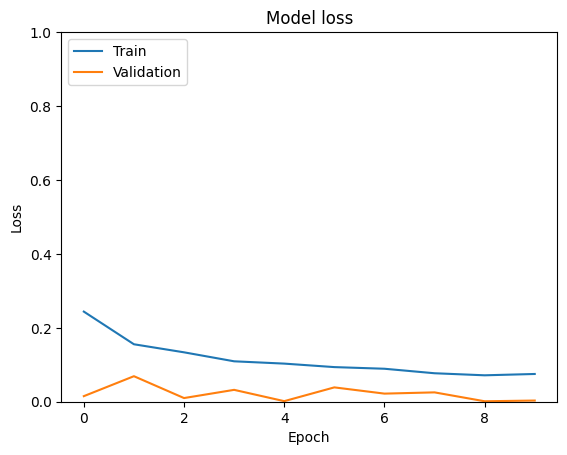

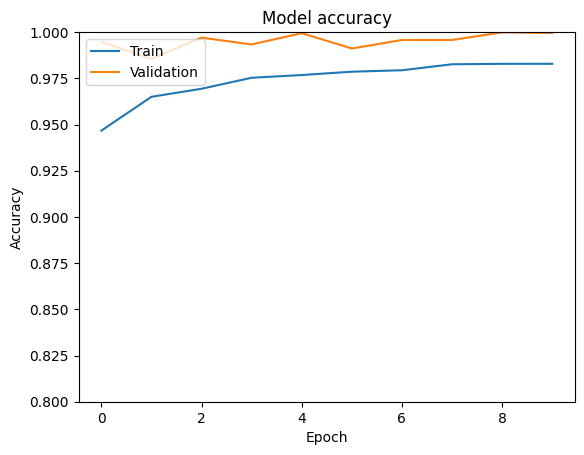

In [56]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)  # Set x-axis range from 0 to 10
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)  # Set x-axis range from 0 to 10
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Test model

In [45]:
model.save('/kaggle/working/best_model.h5') #model after 10 epochs

In [47]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

In [48]:
test_loss , test_accuracy = new_model.evaluate(test_dataset)
print(f'test loss = {test_loss}\ntest accuracy = {test_accuracy}')

272/272 ━━━━━━━━━━━━━━━━━━━━ 65s 227ms/step - accuracy: 0.9992 - loss: 0.0028
test loss = 0.0030739177018404007
test accuracy = 0.9993103742599487


In [50]:
# load best model according to callback which score less validation loss
best_model = tf.keras.models.load_model('/kaggle/working/best_model.keras')

In [51]:
test_loss , test_accuracy = best_model.evaluate(test_dataset)
print(f'test loss = {test_loss}\ntest accuracy = {test_accuracy}')

272/272 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.9992 - loss: 0.0015
test loss = 0.001232723705470562
test accuracy = 0.9994252920150757


## Prediction functions

In [57]:
import cv2
import numpy as np

def preprocess_image(image_path):
  # Load the image
  img = cv2.imread(image_path)
    
  # Resize if necessary
  img = cv2.resize(img, (150, 150))

  # Normalize pixel values (example: 0 to 1)
  img = img.astype('float32') / 255.0
    
  # Expand dimensions for the model (batch size of 1)
  img = np.expand_dims(img, axis=0)  # Add a new dimension for batch size
  return img


In [59]:
def sign_classification(path):
    image = preprocess_image(path)

    # Make a prediction
    prediction = best_model.predict(image)

    # Get index 
    predicted_class_index = np.argmax(prediction[0])

    # Get character of the prediction index
    predicted_char = classes[predicted_class_index]

    return predicted_char

In [64]:
# load images from test file 
test_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
test_data = []
for img in os.listdir(test_path):
    true_char = img.split('_')[0]
    
    img_path = os.path.join(test_path, img)
    
    test_data.append((img_path, true_char))
    

In [67]:
len(test_data)

28

In [66]:
test_data[4:7]

[('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg',
  'S'),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg',
  'D'),
 ('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg',
  'G')]

In [68]:
pred_test = []
for img_path, correct_char in test_data:
    pred_char = sign_classification(img_path)    
    print(f'predicted is: {pred_char}, while ture is: {correct_char}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predicted is: A, while ture is: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted is: E, while ture is: E
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted is: L, while ture is: L
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicted is: N, while ture is: N
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted is: S, while ture is: S
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted is: D, while ture is: D
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: G, while ture is: G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: I, while ture is: I
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted is: W, while ture is: W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: M, while ture is: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: nothing, while ture is: nothing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: X, while ture is: X
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: H, while ture is: H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted is: Q,